# seq2seq

- RNN 기반 번역 모델
- seq2seq 모델 :  시퀀스를 입력받아 또 다른 시퀀스 출력
- 영어 알파벳 문자열을 스페인어 알파벳로 변역하는 미니 seq2seq

import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

In [35]:
vocab_size = 256
x_ = list(map(ord, "hello"))
y_ = list(map(ord, "hola"))
print("hello ->", x_)
print("hola ->", y_)

hello -> [104, 101, 108, 108, 111]
hola -> [104, 111, 108, 97]


In [36]:
x = torch.LongTensor(x_)
y = torch.LongTensor(y_)

In [37]:
class Seq2Seq(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(Seq2Seq, self).__init__()
        self.n_layers = 1
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.encoder = nn.GRU(hidden_size, hidden_size)
        self.decoder = nn.GRU(hidden_size, hidden_size)
        self.project = nn.Linear(hidden_size, vocab_size)

    def forward(self, inputs, targets):
        initial_state = self._init_state()
        embedding = self.embedding(inputs).unsqueeze(1)

        encoder_output, encoder_state = self.encoder(embedding, initial_state)

        decoder_state = encoder_state
        decoder_input = torch.LongTensor([0])

        outputs = []

        for i in range(targets.size()[0]):
            decoder_input = self.embedding(decoder_input).unsqueeze(1)
            decoder_output, decoder_state = self.decoder(decoder_input, decoder_state)
            projection = self.project(decoder_output)
            outputs.append(projection)

            #티처 포싱
            decoder_input = torch.LongTensor([targets[i]])

        outputs = torch.stack(outputs).squeeze()
        return outputs

    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_size).zero_()


In [38]:
seq2seq = Seq2Seq(vocab_size, 16)

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=1e-3)

In [40]:
log = []
for i in range(1000):
    prediction = seq2seq(x,y)
    loss = criterion(prediction, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_val = loss.data
    log.append(loss_val)
    if i%100 == 0:
        print("\n 반복: %d 오차: %s" % (i, loss_val.item()))
        _, top1 = prediction.data.topk(1,1)
        print([chr(c) for c in top1.squeeze().numpy().tolist()])


 반복: 0 오차: 5.565783500671387
['«', 'Í', 'Ð', '\x9c']

 반복: 100 오차: 1.7648676633834839
['h', 'a', 'a', 'a']

 반복: 200 오차: 0.7754544019699097
['h', 'o', 'l', 'a']

 반복: 300 오차: 0.42987385392189026
['h', 'o', 'l', 'a']

 반복: 400 오차: 0.2326800674200058
['h', 'o', 'l', 'a']

 반복: 500 오차: 0.14532600343227386
['h', 'o', 'l', 'a']

 반복: 600 오차: 0.09797339141368866
['h', 'o', 'l', 'a']

 반복: 700 오차: 0.06882104277610779
['h', 'o', 'l', 'a']

 반복: 800 오차: 0.051492251455783844
['h', 'o', 'l', 'a']

 반복: 900 오차: 0.04042237251996994
['h', 'o', 'l', 'a']


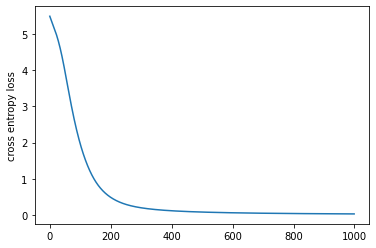

In [34]:
plt.plot(log)
plt.ylabel('cross entropy loss')
plt.show()